In [97]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import datetime
from utils import summary_stats, stats_with_description, plot_time_range, make_features, customCV
from utils import fit_predict_cv_classifier, winsorize_and_scale, Objective, tune_hyperparameters
import re
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import copy

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# from scipy.stats.mstats import winsorize
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import SGDClassifier
# import optuna
# from optuna.visualization import plot_contour
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_param_importances
# import warnings
# from optuna.exceptions import ExperimentalWarning
# import logging
# import sys
# import pickle

In [2]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
CODING_TABLES_FOLDER = '.\\Coding_tables'
STATS_FOLDER = '.\\Stats'
TUNING_FOLDER = '.\\Tuning'
TUNING_CHECKPOINT_FOLDER = '.\\Checkpoints\\Tuning'


if not os.path.exists(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)
if not os.path.exists(TUNING_FOLDER):
    os.makedirs(TUNING_FOLDER)
if not os.path.exists(TUNING_CHECKPOINT_FOLDER):
    os.makedirs(TUNING_CHECKPOINT_FOLDER)

In [3]:
df_fundam_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'))

### Check years distribution

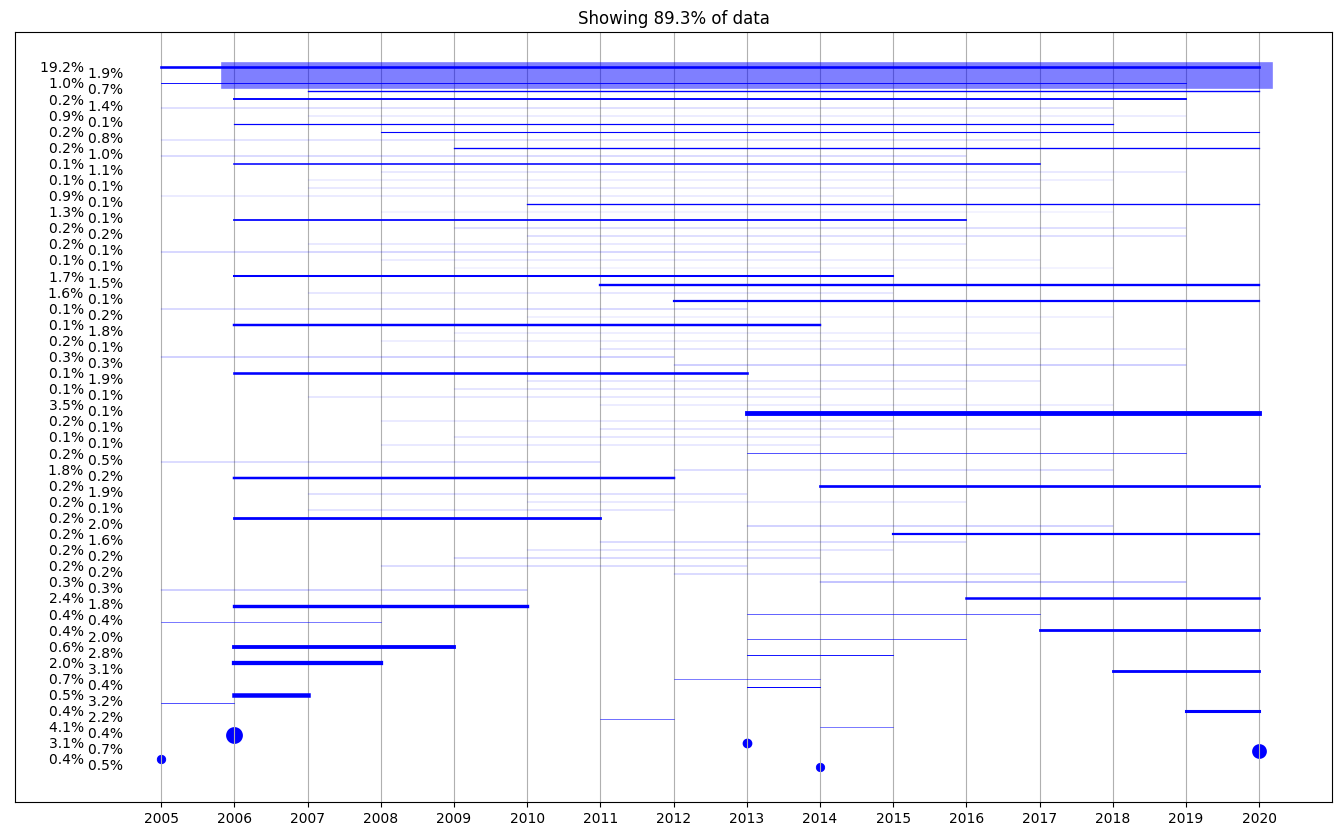

In [5]:
plot_time_range(df=df_fundam_final[df_fundam_final['consec_year_group'] != -1],
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10)

# Replicate paper

*Predicting Future Earnings Changes Using Machine Learning and Detailed Financial Data*  https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12429

### Remove uninformative variables

In [4]:
FILE_NAME = 'df_paper'

# define dataset
df_work = (df_fundam_final[(~df_fundam_final['paper_period'].isna()) &
                           (df_fundam_final['consec_year_group'] != -1) &
                          (~df_fundam_final['LAG_index'].isna())]
          .drop(columns='fyear')
          .rename(columns={'paper_period_year': 'fyear'}))

# create features
df_work = make_features(df_work, df_original = df_fundam_final, thrsh_zeros = 0.3, file_name = FILE_NAME,
                        col_keep = ['main_index', 'fyear', 'EPS_change_next_yr', 'EPS_change_next_yr_detrend'], time_var = 'fyear',
                       CODING_TABLES_FOLDER=CODING_TABLES_FOLDER, STATS_FOLDER=STATS_FOLDER)

# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_work_stats = stats_with_description(df_work, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_work_stats.to_csv(os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'))




- Replacing missing values with zeros

- Removed columns because percentage of zeros is above 30.0 %: 385

- List of variables and percentages saved to .\Stats\01_df_paper_removed_col.csv
- Remaining columns: 135

- Evaluating lagged variables

- Evaluating percentage change
- Replacing NaN and Inf with zeros

- Normalizing by Total Asset
- Replacing Inf with zeros (some lagged total assets may be zero - only for oldest year available)

##### missing values found in:
   -EPS_change_next_yr_detrend: 3


,matched
2012.0,118
2013.0,1212
2014.0,1307
2015.0,1381
2016.0,1374
2017.0,1463
2018.0,1320
Total,8175



- Indices have been resetted

- Stats saved to .\Stats\01a_df_paper_stats.csv


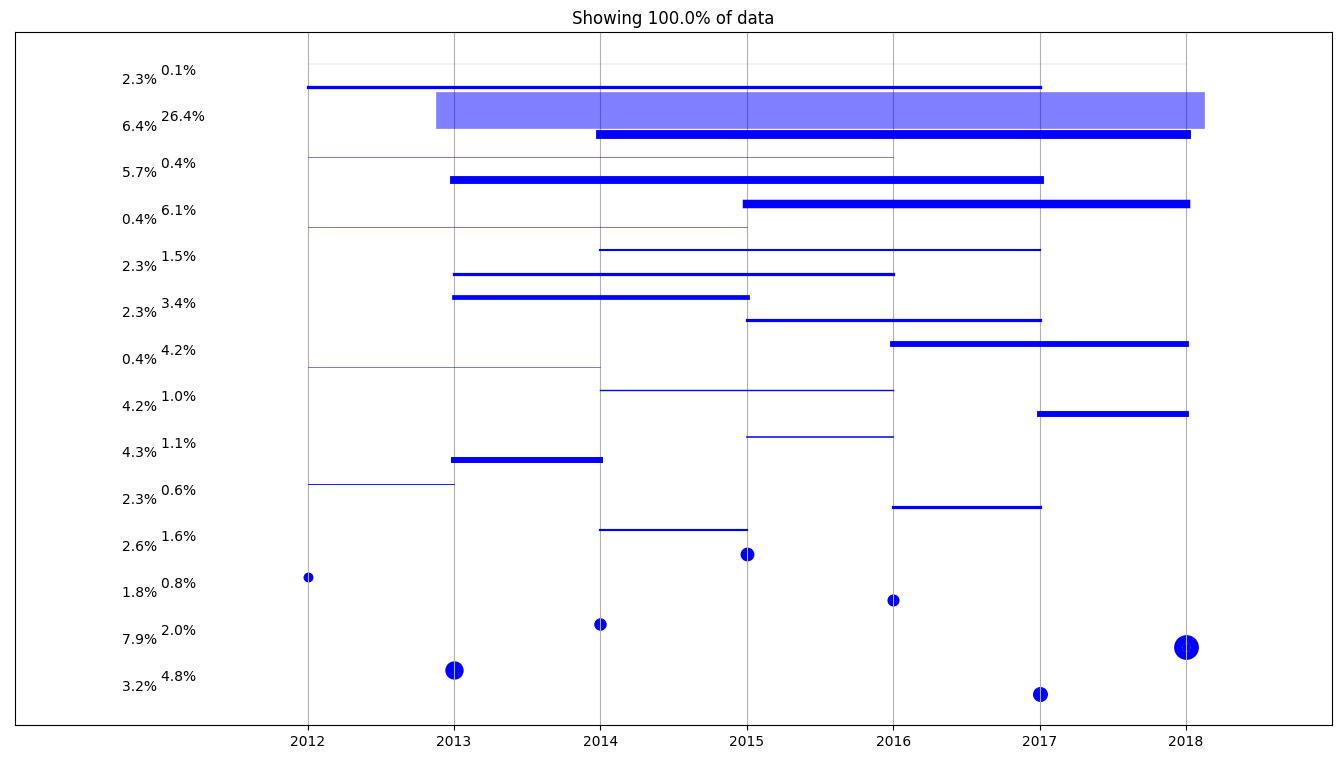

In [7]:
# check time interval

plot_time_range(df=(df_fundam_final.drop(columns=['fyear']).rename(columns={'paper_period_year': 'fyear'})
                    .merge(df_work[['main_index']].assign(cc = lambda x: 1), on='main_index', how='left')
                    .query('cc == 1')),
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10, df_with_lagged_var=True,
                min_obs=0, min_count=0, fig_size=(17, 9))

### Define dataset

In [5]:
# Define final dataset, convert to binary flag, winsorize and scale
df_pred = df_work.copy()
df_pred['fyear'] = df_pred['fyear'].astype(int)
df_pred.index=df_pred['main_index']
df_pred=df_pred.drop(columns=['EPS_change_next_yr_detrend', 'main_index']).rename(columns={'EPS_change_next_yr': 'y'})
df_pred['y'] = np.where(df_pred['y'] > 0, 1, 0)

# winsorize and scale
df_pred=winsorize_and_scale(df_pred, skip_cols=['fyear', 'y'])
# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_pred_stats = stats_with_description(df_pred, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'),
                                       lag_label='_lag1', pc_label='_pc')
df_pred_stats.to_csv(os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'))

display(df_pred.head(5))

display(df_pred['y'].value_counts().to_frame().reset_index().rename(columns={'index': 'flag', 'y': 'count'}).assign(
        perc = lambda x: np.round(x['count'] / x['count'].sum() * 100, 2)))

display(df_pred.groupby('fyear').agg(**{
    'Tot Obs': ('y', 'size'),
    '1': ('y', lambda x: str(sum(x == 1)) + ' (' + str(np.round(sum(x == 1) / len(x) * 100, 1)) +'%)' ),
    '0': ('y', lambda x: str(sum(x == 0)) + ' (' + str(np.round(sum(x == 0) / len(x) * 100, 1)) +'%)' )}))


- Stats saved to .\Stats\01b_df_paper_scaled_stats.csv


,fyear,y,dilavx,seq,ibadj,ebit,at,cshfd,oiadp,lse,icapt,csho,ivncf,ibc,ibcom,niadj,citotal,pi,ib,cibegni,teq,cshpri,ci,ni,oancf,xopr,fincf,ceq,opeps,oprepsx,bkvlps,ceqt,chech,epspi,epspx,che,epsfx,epsfi,lt,ceql,gp,cogs,revt,cshi,fopo,sale,ao,aoloch,rect,re,stkco,emp,ch,ap,lo,ebitda,oibdp,txt,ibmii,dpc,fopox,cshr,dp,reuna,cstk,ppent,capx,aox,cstkcv,txpd,txndb,nopi,aodo,caps,lco,rectr,capxv,xrent,intpn,loxdr,dpact,ppegt,ppeveb,mrc1,txndba,recch,txdi,txndbl,intan,mrc2,acominc,dpvieb,mrc3,xint,aco,nopio,mrct,mrc4,dltt,xsga,xpr,txdc,optosey,act,wcap,lct,optosby,spi,intano,optprcey,optprcby,txc,mrc5,acox,gdwl,optex,mrcta,acodo,lcox,dt,optprcwa,sstk,dltr,fiao,optexd,optprcex,txs,xacc,ivaco,dlc,am,tfva,optca,optprcca,txtubend,txtubbegin,txfed,dilavx_lag1,seq_lag1,ibadj_lag1,ebit_lag1,at_lag1,cshfd_lag1,oiadp_lag1,lse_lag1,icapt_lag1,csho_lag1,ivncf_lag1,ibc_lag1,ibcom_lag1,niadj_lag1,citotal_lag1,pi_lag1,ib_lag1,cibegni_lag1,teq_lag1,cshpri_lag1,ci_lag1,ni_lag1,oancf_lag1,xopr_lag1,fincf_lag1,ceq_lag1,opeps_lag1,oprepsx_lag1,bkvlps_lag1,ceqt_lag1,chech_lag1,epspi_lag1,epspx_lag1,che_lag1,epsfx_lag1,epsfi_lag1,lt_lag1,ceql_lag1,gp_lag1,cogs_lag1,revt_lag1,cshi_lag1,fopo_lag1,sale_lag1,ao_lag1,aoloch_lag1,rect_lag1,re_lag1,stkco_lag1,emp_lag1,ch_lag1,ap_lag1,lo_lag1,ebitda_lag1,oibdp_lag1,txt_lag1,ibmii_lag1,dpc_lag1,fopox_lag1,cshr_lag1,dp_lag1,reuna_lag1,cstk_lag1,ppent_lag1,capx_lag1,aox_lag1,cstkcv_lag1,txpd_lag1,txndb_lag1,nopi_lag1,aodo_lag1,caps_lag1,lco_lag1,rectr_lag1,capxv_lag1,xrent_lag1,intpn_lag1,loxdr_lag1,dpact_lag1,ppegt_lag1,ppeveb_lag1,mrc1_lag1,txndba_lag1,recch_lag1,txdi_lag1,txndbl_lag1,intan_lag1,mrc2_lag1,acominc_lag1,dpvieb_lag1,mrc3_lag1,xint_lag1,aco_lag1,nopio_lag1,mrct_lag1,mrc4_lag1,dltt_lag1,xsga_lag1,xpr_lag1,txdc_lag1,optosey_lag1,act_lag1,wcap_lag1,lct_lag1,optosby_lag1,spi_lag1,intano_lag1,optprcey_lag1,optprcby_lag1,txc_lag1,mrc5_lag1,acox_lag1,gdwl_lag1,optex_lag1,mrcta_lag1,acodo_lag1,lcox_lag1,dt_lag1,optprcwa_lag1,sstk_lag1,dltr_lag1,fiao_lag1,optexd_lag1,optprcex_lag1,txs_lag1,xacc_lag1,ivaco_lag1,dlc_lag1,am_lag1,tfva_lag1,optca_lag1,optprcca_lag1,txtubend_lag1,txtubbegin_lag1,txfed_lag1,dilavx_pc,seq_pc,ibadj_pc,ebit_pc,at_pc,cshfd_pc,oiadp_pc,lse_pc,icapt_pc,csho_pc,ivncf_pc,ibc_pc,ibcom_pc,niadj_pc,citotal_pc,pi_pc,ib_pc,cibegni_pc,teq_pc,cshpri_pc,ci_pc,ni_pc,oancf_pc,xopr_pc,fincf_pc,ceq_pc,opeps_pc,oprepsx_pc,bkvlps_pc,ceqt_pc,chech_pc,epspi_pc,epspx_pc,che_pc,epsfx_pc,epsfi_pc,lt_pc,ceql_pc,gp_pc,cogs_pc,revt_pc,cshi_pc,fopo_pc,sale_pc,ao_pc,aoloch_pc,rect_pc,re_pc,stkco_pc,emp_pc,ch_pc,ap_pc,lo_pc,ebitda_pc,oibdp_pc,txt_pc,ibmii_pc,dpc_pc,fopox_pc,cshr_pc,dp_pc,reuna_pc,cstk_pc,ppent_pc,capx_pc,aox_pc,cstkcv_pc,txpd_pc,txndb_pc,nopi_pc,aodo_pc,caps_pc,lco_pc,rectr_pc,capxv_pc,xrent_pc,intpn_pc,loxdr_pc,dpact_pc,ppegt_pc,ppeveb_pc,mrc1_pc,txndba_pc,recch_pc,txdi_pc,txndbl_pc,intan_pc,mrc2_pc,acominc_pc,dpvieb_pc,mrc3_pc,xint_pc,aco_pc,nopio_pc,mrct_pc,mrc4_pc,dltt_pc,xsga_pc,xpr_pc,txdc_pc,optosey_pc,act_pc,wcap_pc,lct_pc,optosby_pc,spi_pc,intano_pc,optprcey_pc,optprcby_pc,txc_pc,mrc5_pc,acox_pc,gdwl_pc,optex_pc,mrcta_pc,acodo_pc,lcox_pc,dt_pc,optprcwa_pc,sstk_pc,dltr_pc,fiao_pc,optexd_pc,optprcex_pc,txs_pc,xacc_pc,ivaco_pc,dlc_pc,am_pc,tfva_pc,optca_pc,optprcca_pc,txtubend_pc,txtubbegin_pc,txfed_pc
main_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,2015,1,0.027737,0.600374,0.027737,0.045836,0.315900,0.023993,0.045836,1.0,0.694751,0.023934,-0.011719,0.028084,0.028084,0.032730,0.030303,0.041121,0.028084,0.033077,0.600374,0.023854,0.030303,0.033077,0.022259,0.105797,-0.026628,0.600374,0.007628,0.007558,0.173946,0.483462,-0.016

,flag,count,perc
0,1,4660,57.0
1,0,3515,43.0


,Tot Obs,1,0
fyear,,,
2012,118,61 (51.7%),57 (48.3%)
2013,1212,706 (58.3%),506 (41.7%)
2014,1307,737 (56.4%),570 (43.6%)
2015,1381,690 (50.0%),691 (50.0%)
2016,1374,802 (58.4%),572 (41.6%)
2017,1463,835 (57.1%),628 (42.9%)
2018,1320,829 (62.8%),491 (37.2%)


### Tune ML models

In [6]:
TOT_TRIALS = 100
MEASURE = f1_score
CV_ITERATOR = customCV(n_train_years=2, n_test_years=1, rolling_wind_step=1, train_test_offset=0,
                       year_variable='fyear', back_ward=False, show_info=False)
OUT_OF_SAMPLE_YEARS = 1
TIME_VAR = 'fyear'
ADD_MEASURE = [roc_auc_score, accuracy_score, precision_score, recall_score]
OPTIM_MEASURE = 'valid_best'    # find best hyperparameters according to validation score (best means with optimized threshold)

RELOAD = False

In [10]:
# loop over models

for mod in ['ElasticNet', 'RandomForest', 'LightGBM']:
    
    print('#'*(70+len(mod)+4))
    print('#'+' '*35, mod, ' '*35+'#')
    print('#'*(70+len(mod)+4),'\n\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              optim_measure=OPTIM_MEASURE, file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER, reload=RELOAD)
    print('\n\n')

####################################################################################
#                                    ElasticNet                                    #
#################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_ElasticNet_f1_score.db 

- Started at: 04/12/2022 03:50:39 

Trial 100 / 100     avg elapsed time:  0:00:11
Total elapsed time: 0:18:29

- Pickle saved to .\Tuning\df_paper_ElasticNet_f1_score.pkl


Optimal score: 0.7185509004121186
Best params:
 {'alpha': 0.0001, 'eta0': 0.9998002369701828, 'l1_ratio': 0

In [99]:
mod = 'ElasticNet'
    
TOT_TRIALS=5
print('#'*(70+len(mod)+4))
print('#'+' '*35, mod, ' '*35+'#')
print('#'*(70+len(mod)+4),'\n\n')
study, study_log=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                          time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE, optim_measure=OPTIM_MEASURE,
                          file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                          tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER, reload=False)

####################################################################################
#                                    ElasticNet                                    #
#################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_ElasticNet_f1_score.db 

- Started at: 13/12/2022 21:48:29 

Trial 5 / 5     avg elapsed time:  0:00:00   current optimal value: 0.7171726031002923                               
- Pickle saved to .\Tuning\df_paper_ElasticNet_f1_score.pkl

Total elapsed time: 0:00:02


Optimization metric: f1_score on val

,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
5,F1,0.143,0.723214,0.717173,0.730094,0.680635,0.610046,0.630396
5,ROC_AUC,,0.730693,0.608306,0.641606,,,
5,ACCURACY,0.143,0.576904,0.566471,0.583373,0.660349,0.5779,0.599271
5,PRECISION,0.143,0.567933,0.561614,0.578494,0.712162,0.623919,0.664072
5,RECALL,0.143,0.996120,0.994119,0.993370,0.652208,0.598293,0.602334



- Tuning log saved to .\Tuning\df_paper_ElasticNet_f1_score.csv


In [100]:
mod = 'ElasticNet'
    
TOT_TRIALS=5
print('#'*(70+len(mod)+4))
print('#'+' '*35, mod, ' '*35+'#')
print('#'*(70+len(mod)+4),'\n\n')
study, study_log=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                          time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE, optim_measure=OPTIM_MEASURE,
                          file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                          tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER, reload=True)

####################################################################################
#                                    ElasticNet                                    #
#################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)



- Session reloaded

Total elapsed time: 0:00:02


Optimization metric: f1_score on valid_best
Optimal score: 0.7171726031002923   (Trial 5)
Best params:
 {'alpha': 0.0, 'eta0': 0.09349551959463466, 'l1_ratio': 0.15367390200000686}
Best params performance:


,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
5,F1,0.143,0.723214,0.717173,0.730094,0.680635,0.610046,0.630396
5,ROC_AUC,,0.730693,0.608306,0.641606,,,
5,ACCURACY,0.143,0.576904,0.566471,0.583373,0.660349,0.5779,0.599271
5,PRECISION,0.143,0.567933,0.561614,0.578494,0.712162,0.623919,0.664072
5,RECALL,0.143,0.996120,0.994119,0.993370,0.652208,0.598293,0.602334



- Tuning log saved to .\Tuning\df_paper_ElasticNet_f1_score.csv


In [84]:
study_log.duration.sum()

Timedelta('0 days 00:07:41.583450')

In [89]:
study_log.duration.sum().total_seconds()

461.58345

In [90]:
str(datetime.timedelta(seconds=round(study_log.duration.sum().total_seconds())))

'0:07:42'

In [85]:
study_log

,number,value,datetime_start,datetime_complete,duration,alpha,eta0,l1_ratio,state,pkl,F1.best_thresh,F1.train_best,F1.valid_best,F1.test_best,F1.train_05,F1.valid_05,F1.test_05,ROC_AUC.train_best,ROC_AUC.valid_best,ROC_AUC.test_best,ACCURACY.train_best,ACCURACY.valid_best,ACCURACY.test_best,ACCURACY.best_thresh,ACCURACY.train_05,ACCURACY.valid_05,ACCURACY.test_05,PRECISION.train_best,PRECISION.valid_best,PRECISION.test_best,PRECISION.best_thresh,PRECISION.train_05,PRECISION.valid_05,PRECISION.test_05,RECALL.train_best,RECALL.valid_best,RECALL.test_best,RECALL.best_thresh,RECALL.train_05,RECALL.valid_05,RECALL.test_05
0,0,0.712833,2022-12-09 01:06:15.846913,2022-12-09 01:06:16.416702,0 days 00:00:00.569789,0.10000,0.000016,0.508066,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.000,0.714029,0.712833,0.725429,0.357758,0.348266,0.377163,0.500000,0.500000,0.500000,0.555494,0.554492,0.570528,0.000,0.501709,0.480700,0.535336,0.555494,0.554492,0.570528,0.000,0.278602,0.267596,0.302932,1.000000,1.000000,1.000000,0.000,0.500000,0.500000,0.500000
1,1,0.713047,2022-12-09 01:06:16.619806,2022-12-09 01:06:17.131147,0 days 00:00:00.511341,0.10000,0.023117,0.023236,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.434,0.713469,0.713047,0.724320,0.603854,0.595220,0.620006,0.612584,0.577819,0.582733,0.557222,0.557502,0.570711,0.434,0.580252,0.554011,0.564722,0.557101,0.556429,0.570802,0.434,0.633167,0.600703,0.619049,0.993143,0.994434,0.994456,0.434,0.577772,0.593479,0.627141
2,2,0.713853,2022-12-09 01:06:17.369508,2022-12-09 01:06:17.670406,0 days 00:00:00.300898,0.01000,0.081892,0.626405,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.430,0.714110,0.713853,0.723180,0.587125,0.577559,0.599228,0.593500,0.564020,0.559617,0.559811,0.560661,0.570347,0.430,0.565928,0.541416,0.549315,0.558898,0.558336,0.570741,0.430,0.620790,0.593311,0.608148,0.990280,0.991345,0.989999,0.430,0.557948,0.565895,0.594383
3,3,0.717173,2022-12-09 01:06:17.830967,2022-12-09 01:06:18.094101,0 days 00:00:00.263134,0.00000,0.093496,0.153674,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.143,0.723214,0.717173,0.730094,0.680635,0.610046,0.630396,0.730693,0.608306,0.641606,0.576904,0.566471,0.583373,0.143,0.660349,0.577900,0.599271,0.567933,0.561614,0.578494,0.143,0.712162,0.623919,0.664072,0.996120,0.994119,0.993370,0.143,0.652208,0.598293,0.602334
4,4,0.713916,2022-12-09 01:06:18.257357,2022-12-09 01:06:18.487093,0 days 00:00:00.229736,0.01000,0.229623,0.353778,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.392,0.715311,0.713916,0.725316,0.605910,0.599578,0.621915,0.627080,0.591542,0.594654,0.562670,0.560945,0.574512,0.392,0.583516,0.558915,0.571987,0.560492,0.558545,0.573327,0.392,0.638573,0.604575,0.625428,0.989750,0.991006,0.990619,0.392,0.577599,0.598270,0.624031
5,5,0.712833,2022-12-09 01:06:18.628320,2022-12-09 01:06:18.839956,0 days 00:00:00.211636,1.00000,0.000384,0.256564,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.000,0.714029,0.712833,0.725429,0.355495,0.350869,0.365963,0.500000,0.500000,0.500000,0.555494,0.554492,0.570528,0.000,0.496368,0.487176,0.506694,0.555494,0.554492,0.570528,0.000,0.275931,0.270834,0.288611,1.000000,1.000000,1.000000,0.000,0.500000,0.500000,0.500000
6,6,0.712833,2022-12-09 01:06:18.981685,2022-12-09 01:06:19.186538,0 days 00:00:00.204853,100.00000,0.020764,0.738471,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.000,0.714029,0.712833,0.725429,0.531148,0.532549,0.558843,0.500000,0.500000,0.500000,0.555494,0.554492,0.570528,0.000,0.517148,0.522548,0.570709,0.555494,0.554492,0.570528,0.000,0.411321,0.413520,0.445618,1.000000,1.000000,1.000000,0.000,0.750000,0.750000,0.750000
7,7,0.716094,2022-12-09 01:06:19.331698,2022-12-09 01:06:19.549054,0 days 00:00:00.217356,0.00010,0.022974,0.036433,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.215,0.721109,0.716094,0.729176,0.667094,0.614592,0.633947,0.703209,0.604798,0.630784,0.573611,0.564467

In [68]:
study_log[study_log['number'] == study.best_trial.number]

,number,value,datetime_start,datetime_complete,duration,alpha,eta0,l1_ratio,state,pkl,F1.best_thresh,F1.split,F1.train_best,F1.valid_best,F1.test_best,F1.train_05,F1.valid_05,F1.test_05,ROC_AUC.split,ROC_AUC.train_best,ROC_AUC.valid_best,ROC_AUC.test_best,ACCURACY.split,ACCURACY.train_best,ACCURACY.valid_best,ACCURACY.test_best,ACCURACY.best_thresh,ACCURACY.train_05,ACCURACY.valid_05,ACCURACY.test_05,PRECISION.split,PRECISION.train_best,PRECISION.valid_best,PRECISION.test_best,PRECISION.best_thresh,PRECISION.train_05,PRECISION.valid_05,PRECISION.test_05,RECALL.split,RECALL.train_best,RECALL.valid_best,RECALL.test_best,RECALL.best_thresh,RECALL.train_05,RECALL.valid_05,RECALL.test_05
64,64,0.718551,2022-12-09 01:06:39.081819,2022-12-09 01:06:39.246418,0 days 00:00:00.164599,0.0001,0.9998,0.480491,COMPLETE,.\Checkpoints\Tuning\df_paper_ElasticNet_f1_sc...,0.07,1.5,0.727144,0.718551,0.729541,0.700469,0.606149,0.631009,1.5,0.752248,0.606427,0.647511,1.5,0.585465,0.571901,0.586299,0.07,0.679391,0.573555,0.602253,1.5,0.573349,0.565388,0.580258,0.07,0.72652,0.620034,0.668772,1.5,0.994995,0.988129,0.98481,0.07,0.676339,0.594155,0.600921


In [79]:
optim_measure='valid_best'
measure = f1_score


avail_measure = study_log.columns[study_log.columns.str.endswith(optim_measure)].str.replace('.'+optim_measure, '', regex=True).tolist()
avail_set = study_log.columns[study_log.columns.str.startswith(avail_measure[0])].str.replace(avail_measure[0]+'.', '', regex=True).tolist()
best_row = study_log[study_log['number'] == study.best_trial.number]

df_best = pd.DataFrame()
for meas in avail_measure:
    common_cols = set([meas+'.'+x for x in avail_set]) & set(best_row.columns)
    add_df = best_row.loc[:, common_cols]
    add_df.columns = add_df.columns.str.replace(meas+'.', '', regex=True)
    add_df.insert(0, 'Performance', meas)
    df_best = df_best.append(add_df)
df_best=df_best.fillna('')#.fillna(method='bfill').fillna(method='ffill')
# df_best=df_best[[df_best.columns[df_best.columns.str.contains(x)][0] for x in ['Performance', 'thresh', 'train', 'valid', 'test']]]
df_best=df_best[['Performance', 'best_thresh', 'train_best', 'valid_best', 'test_best', 'train_05', 'valid_05', 'test_05']]
print('Best params performance:')
display(df_best)

Best params performance:


,Performance,best_thresh,train_best,valid_best,test_best,train_05,valid_05,test_05
64,F1,0.07,0.727144,0.718551,0.729541,0.700469,0.606149,0.631009
64,ROC_AUC,,0.752248,0.606427,0.647511,,,
64,ACCURACY,0.07,0.585465,0.571901,0.586299,0.679391,0.573555,0.602253
64,PRECISION,0.07,0.573349,0.565388,0.580258,0.72652,0.620034,0.668772
64,RECALL,0.07,0.994995,0.988129,0.984810,0.676339,0.594155,0.600921


In [80]:
measure.__name__

'f1_score'

In [71]:
common_cols

{'RECALL.best_thresh',
 'RECALL.split',
 'RECALL.test_05',
 'RECALL.test_best',
 'RECALL.train_05',
 'RECALL.train_best',
 'RECALL.valid_05',
 'RECALL.valid_best'}

In [54]:
best_row.pkl.values[0]

'.\\Checkpoints\\Tuning\\df_paper_ElasticNet_f1_score\\alpha0.0001-eta00.9998002369701828-l1_ratio0.4804910140065178.pkl'

In [55]:
with open(best_row.pkl.values[0], 'rb') as handle:
    pkl_reload = pickle.load(handle)

In [59]:
pkl_reload['perf']

,split,train_best,valid_best,test_best,best_thresh,train_05,valid_05,test_05
0,0,0.752603,0.730691,0.671717,0.07,0.745602,0.631861,0.599308
1,1,0.737625,0.670582,0.739252,0.07,0.690381,0.566308,0.608696
2,2,0.705125,0.741395,0.729991,0.07,0.679542,0.626553,0.611825
3,3,0.713223,0.731535,0.777202,0.07,0.686349,0.599873,0.704207


In [58]:
pkl_reload['perf_add']

{'roc_auc_score':    split  train_best  valid_best  test_best
 0      0    0.791194    0.596536   0.621345
 1      1    0.736192    0.606053   0.636917
 2      2    0.733219    0.627522   0.616110
 3      3    0.748389    0.595595   0.715671,
 'accuracy_score':    split  train_best  valid_best  test_best  best_thresh  train_05  valid_05  \
 0      0    0.624812    0.594491   0.529327         0.07  0.717293  0.579189   
 1      1    0.593886    0.512672   0.593886         0.07  0.661374  0.561912   
 2      2    0.556920    0.595342   0.580314         0.07  0.666667  0.584425   
 3      3    0.566243    0.585099   0.641667         0.07  0.672232  0.568694   
 
     test_05  
 0  0.580739  
 1  0.587336  
 2  0.587150  
 3  0.653788  ,
 'precision_score':    split  train_best  valid_best  test_best  best_thresh  train_05  valid_05  \
 0      0    0.607200    0.584078   0.515504         0.07  0.774965  0.623514   
 1      1    0.585505    0.506282   0.591181         0.07  0.724848  0.5602

In [38]:
df_best.fillna(method='bfill').fillna(method='ffill')

,Performance,best_thresh,valid_best,test_best,train_best
64,F1,0.07,0.718551,0.729541,0.727144
64,ROC_AUC,0.07,0.606427,0.647511,0.752248
64,ACCURACY,0.07,0.571901,0.586299,0.585465
64,PRECISION,0.07,0.565388,0.580258,0.573349
64,RECALL,0.07,0.988129,0.984810,0.994995


In [23]:
type(0.0021) is float

True

In [21]:
study.best_trial


FrozenTrial(number=64, values=[0.7185509004121186], datetime_start=datetime.datetime(2022, 12, 7, 11, 34, 48, 415256), datetime_complete=datetime.datetime(2022, 12, 7, 11, 34, 48, 548294), params={'alpha': 0.0001, 'eta0': 0.9998002369701828, 'l1_ratio': 0.4804910140065178}, distributions={'alpha': CategoricalDistribution(choices=(1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0)), 'eta0': FloatDistribution(high=1.0, log=True, low=1e-06, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=65, state=TrialState.COMPLETE, value=None)

In [30]:
from utils import fit_predict_cv_classifier, winsorize_and_scale, Objective, tune_hyperparameters

for mod in ['LightGBM']:
    
    print('#'*(70+len(mod)+4))
    print('#'+' '*35, mod, ' '*35+'#')
    print('#'*(70+len(mod)+4),'\n\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              optim_measure=OPTIM_MEASURE, file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER)
    print('\n\n')

##################################################################################
#                                    LightGBM                                    #
################################################################################## 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_LightGBM_f1_score.db 

- Started at: 09/12/2022 01:02:09 

{'n_estimators': 59, 'max_depth': 6, 'min_child_samples': 8, 'reg_alpha': 0.001, 'reg_lambda': 0.0, 'colsample_bytree': 0.9140969416863527, 'learning_rate': 0.020093222849316528, 'subsample': 0.11773843568279735}
{'n_estimators': 76, 'max_depth': 4, 'mi

[W 2022-12-09 01:02:50,061] Trial 80 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 808, in fit_predict_cv_classifier
    fit_model = model.fit(X_train,y=y_train)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 972, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 758, in fit
    callbacks=callbacks
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\light

Trial 80 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 808, in fit_predict_cv_classifier
    fit_model = model.fit(X_train,y=y_train)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 972, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 758, in fit
    callbacks=callbacks
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\engine.py", line 292, in

Trial 80 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 808, in fit_predict_cv_classifier
    fit_model = model.fit(X_train,y=y_train)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 972, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\sklearn.py", line 758, in fit
    callbacks=callbacks
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\lightgbm\engine.py", line 292, in

KeyboardInterrupt: 

In [34]:
for mod in ['ElasticNet']:
    
    print('#'*(70+len(mod)+4))
    print('#'+' '*35, mod, ' '*35+'#')
    print('#'*(70+len(mod)+4),'\n\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              optim_measure=OPTIM_MEASURE, file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER)
    print('\n\n')

####################################################################################
#                                    ElasticNet                                    #
#################################################################################### 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_ElasticNet_f1_score.db 

- Started at: 09/12/2022 01:04:32 

{'alpha': 0.0001, 'l1_ratio': 0.4859171862679831, 'eta0': 1.0169835360885356e-06}                    
{'alpha': 0.0001, 'l1_ratio': 0.4616390809491874, 'eta0': 0.8135896024513922}09004121186                               


[W 2022-12-09 01:04:45,216] Trial 101 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 975, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 689, in to_labels
    return (pos_probs >= threshold).astype('int')
Key

Trial 101 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 975, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 689, in to_labels
    return (pos_probs >= threshold).astype('int')
KeyboardInterrupt
Trial 101 fai

Trial 101 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 975, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 689, in to_labels
    return (pos_probs >= threshold).astype('int')
KeyboardInterrupt
Trial 101 fai

KeyboardInterrupt: 

In [32]:
for mod in ['LightGBM']:
    
    print('#'*(70+len(mod)+4))
    print('#'+' '*35, mod, ' '*35+'#')
    print('#'*(70+len(mod)+4),'\n\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              optim_measure=OPTIM_MEASURE, file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER)
    print('\n\n')

##################################################################################
#                                    LightGBM                                    #
################################################################################## 


Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_LightGBM_f1_score.db 

- Started at: 09/12/2022 01:03:36 

{'n_estimators': 47, 'max_depth': 2, 'min_child_samples': 4, 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'colsample_bytree': 0.8343331868781562, 'learning_rate': 0.01074941078639587, 'subsample': 0.08554085439504465}


[W 2022-12-09 01:03:43,417] Trial 83 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\sklearn\metrics\_classification.py", line 1131, in f1_score
    zero_division=zero_divisi

Trial 83 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\sklearn\metrics\_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "C:\Users\Alessan

Trial 83 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\sklearn\metrics\_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "C:\Users\Alessan

Trial 83 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\sklearn\metrics\_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "C:\Users\Alessan

Trial 83 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 974, in __call__
    return_model=(True if self.model_save_path is not None else False))
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in fit_predict_cv_classifier
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\Downloads\UniPV\Lim\WRDS_accounting\utils.py", line 820, in <listcomp>
    [measure(y_valid, to_labels(y_pred_valid, t)) for t in thresholds]},
  File "C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\sklearn\metrics\_classification.py", line 1131, in f1_score
    zero_division=zero_division,
  File "C:\Users\Alessan

KeyboardInterrupt: 

In [4]:
import shap
# import lightgbm as lgb
from lightgbm import LGBMClassifier
shap.initjs()


In [5]:
from sklearn.datasets import load_iris
data = load_iris()
X=data['data']
y=data['target']

In [11]:
model = LGBMClassifier(num_leaves=2, colsample_bytree=0.7818569233881354)
model.fit(X,y=y)

LGBMClassifier(num_leaves=2)

In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [50]:
X_display = pd.DataFrame(X, columns=data['feature_names'])
X_display

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [51]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

In [7]:
model.predict_proba(X)[:, 1]

array([1.38238969e-05, 6.61375097e-05, 1.26178886e-05, 1.94828759e-05,
       1.00090365e-05, 1.79618397e-05, 7.03377575e-06, 9.54194463e-06,
       1.08372733e-04, 1.94855176e-05, 1.73291382e-05, 6.50294005e-06,
       6.61356979e-05, 6.61106647e-05, 5.60277939e-05, 2.93530830e-05,
       1.84405850e-05, 1.38979201e-05, 3.04700141e-05, 1.30841532e-05,
       1.81180799e-05, 1.30395714e-05, 6.90721252e-06, 8.75111569e-04,
       4.86216766e-04, 8.90319845e-05, 9.43782414e-06, 1.52239205e-05,
       1.63749320e-05, 1.17299968e-05, 1.92352604e-05, 1.75817800e-05,
       1.52239205e-05, 3.11186297e-05, 1.94855176e-05, 1.82772406e-05,
       3.11102158e-05, 6.91001746e-06, 6.61106647e-05, 1.31787792e-05,
       1.00599116e-05, 1.30862719e-03, 1.26165236e-05, 4.97269759e-04,
       9.80663266e-04, 6.64898116e-05, 1.28476673e-05, 1.26199359e-05,
       1.73291382e-05, 1.21982812e-05, 9.99982856e-01, 9.99957398e-01,
       9.99928161e-01, 9.99893361e-01, 9.99910064e-01, 9.99969866e-01,
      

In [67]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 10,
    "boost_from_average": True,
    "num_iterations": 1000
}

model1 = lgb.train(params, lgb.Dataset(data=X, label=y))

Found `num_iterations` in params. Will use it instead of argument


In [65]:
model.predict_proba(X)[:, 1].shape

(150,)

In [68]:
model1.predict(X).shape

(150,)